---
Project for the Research Module in Econometrics and Statistics | Winter Semester 2021-2022 | University of Bonn
[Hugo Foerster-Baldenius](https://github.com/hugo-fb) and [Muhammad Danial Syed](https://github.com/CasualDan) <br>

---
# Replication kit for Debiased machine learning
#### by Hugo Foerster-Baldenius and Muhammad Danial Syed

This notebook contains our project based on the Double Machine Learning method introduced in [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (Chernozhukov et al., 2018)

The following packages are used:
- [DoubleML](https://docs.doubleml.org/stable/index.html)
- [MLR3 Learners](https://mlr3learners.mlr-org.com)

#### Source material
The project uses the above `DoubleML` package for its main computations and also relies on certain modifications of the [source code](https://github.com/DoubleML/doubleml-for-r) to alter the data generating process.

We also adapt the code for M-bias to test for violations of unconfoundedness from the online appendix available at [Double Machine Learning and Automated Confounder Selection](https://arxiv.org/abs/2108.11294) (Hünermund et al., 2021)

#### Overview

Part I: A multi-part simulation study that complements the theoretical portion of our term paper and critically examines some of the main properties of DML:
1. Naive ML application to a semiparametric model
2. DML Estimator with and without cross-fitting.
3. DML Estimator with and without a pre-treatment confounder. (M-Bias)
4. Finite Sample Sensitivity of DML to k-Fold sample split.

Part II: A two-pronged robustness check of the empirical applicability of DML.
1. *Son Preferences in the United States* (Blau et al., 2020)
2. *Saving by Default:  Evidence from a Field Experiment in Rural India* (Somville and Vandewalle, 2018)

---
## Part I: Simulation Studies
---

### Setup

#### Initialization 

In [119]:
rm(list=ls())

library(repr)
library(mlr3)
library(xtable)
library(ggplot2)
library(mvtnorm)
library("readxl")
library(DoubleML)
library(data.table)
library(mlr3learners)
suppressMessages(library(doMC))
suppressMessages(library(parallel))
suppressMessages(library(clusterGeneration))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

#### Using LASSO as the Machine Learning Method for Estimating $g_{0}$ and $m_{0}$

In [159]:
# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  # use LASSO to estimate nuisance g() and m()
    m_hat <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat)   # initialize the DML Partially Linear Model 
    DML_PLR$fit()                                             # Fit the model and extract coefficient estimates
    theta_hat <- DML_PLR$coef
    sd_hat    <- DML_PLR$se
    params    <- cbind(theta_hat,sd_hat)
    return(params)
}

#### Default Data Generating Process - Chernozhukov et al. (2018)

In [160]:
generate_DGP <- function(n_obs,dim_x,theta,seed) {
    
    set.seed(seed)
    #multiplicatives in nuisance functions  
    a_1 = 0.25
    b_1 = 0.25
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # Toeplitz covariance matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    x       <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat) 
    
    # nuisance parameter m_0 and propensity function d  
    m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    d     <- as.matrix(m_0_x + eps)
    
    # nuisance paraneter g_0 and outcome y
    g_0_x <- exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3]
    y     <- as.matrix(theta*d + g_0_x + ups)

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
} 

#### Confounded DGP - Hünermund et al (2021)

In [161]:
# pre treatment confounder: test at n_con = 1
confounded_DGP <- function(n_obs,dim_x,theta,seed,n_con) {
    
    set.seed(seed)
    a_1 = 0.25
    b_1 = 0.25
    c_1 = 0.8
    c_2 = 0.2
    
    u1  <- rnorm(n_obs)  # unobserved
    u2  <- rnorm(n_obs)  # unobserved correlation with y
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # constructing covariates matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1 - n_con)))
    
    x     <- rmvnorm(n = n_obs, mean = rep(0, dim_x-n_con), sigma = cov_mat)        # covariate matrix, unconfounded
    x_con <- matrix(rnorm(n_obs * n_con), ncol = n_con) + sqrt(c_1) * u1 + sqrt(c_2) * u2    # bad controls
    
    if (n_con == 0) {
        x <- x
    } else {
        x <- cbind(x,x_con)
    }
    
    # nuisance parameter m_0 and propensity function d
    m_0_x <- x[,1] + a_1 * (exp(x[,3])/(1 + exp(x[,3]))) 
    d     <- as.matrix(m_0_x + sqrt(c_1) * u1 + eps)
    
    # nuisance paraneter g_0
    g_0_x <-  exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3]
    
    y <- as.matrix(theta*d + g_0_x + sqrt(c_2) * u2 + ups)

    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
}

#### Turrell Data Generating Process - Adapted from DoubleML Source Code 

In [162]:
turrell_DGP <- function(n_obs,dim_x,theta,seed,nu=0,gamma=1) {
    
    m = function(x, nu = 0, gamma = 1) {
        y = 0.5 / pi * sinh(gamma) / (cosh(gamma) - cos(x - nu))
        return(y)
    }
    
    g = function(x) {
        y = sin(x)^2
        return(y)
    }
    
    set.seed(seed)
    b = 1 / (1:dim_x)
    sigma = genPositiveDefMat(dim_x)
    x = rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = sigma$Sigma)
    G = g(x %*% b)
    M = m(x %*% b, nu = nu, gamma = gamma)
    d = M + rnorm(n_obs)
    y = as.matrix(theta * d + G + rnorm(n_obs))

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
}

#### Simulation Function

In [163]:
sim_function <- function(data){
    
    DML_data     <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    param_output <- est_lasso(DML_data) 
    return(param_output)
}

#### Parameter Setup

In [164]:
### Initial Fixed Design Parameters
n_rep = 10000       #set to 10,000
n_vars = 150
n_obs  = 200
theta  = 1

## Simulation Studies

1 - Naive Estimator using LASSO

2 - DML with and without cross-fitting

3 - DML with and without endogenous control

4 - Finite Sample Cross-fitting

### 1) Naïve Estimate with equal sample split - Figure 1

In [126]:
theta_hat_naive <- rep(NA, n_rep)

# Simulating the estimator 10,000 times with different data each time
for (i in 1:n_rep) {
    data = generate_DGP(theta=theta, n_obs=n_obs, dim_x=n_vars, seed=i) 
    
    task_g  <- TaskRegr$new(id = "data", backend = data, target = "y")
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    
    train_set <- sample(task_g$nrow, 0.5 * task_g$nrow)
    test_set  <- setdiff(seq_len(task_g$nrow), train_set)

    # train the model
    learner$train(task_g, row_ids = train_set)

    # predict data
    g_hat <- learner$predict(task_g, row_ids = test_set)
    theta_hat_naive[i] <- (mean(data[test_set,]$d*(data[test_set,]$y - g_hat$response)))/mean(data[test_set,]$d^2)

}

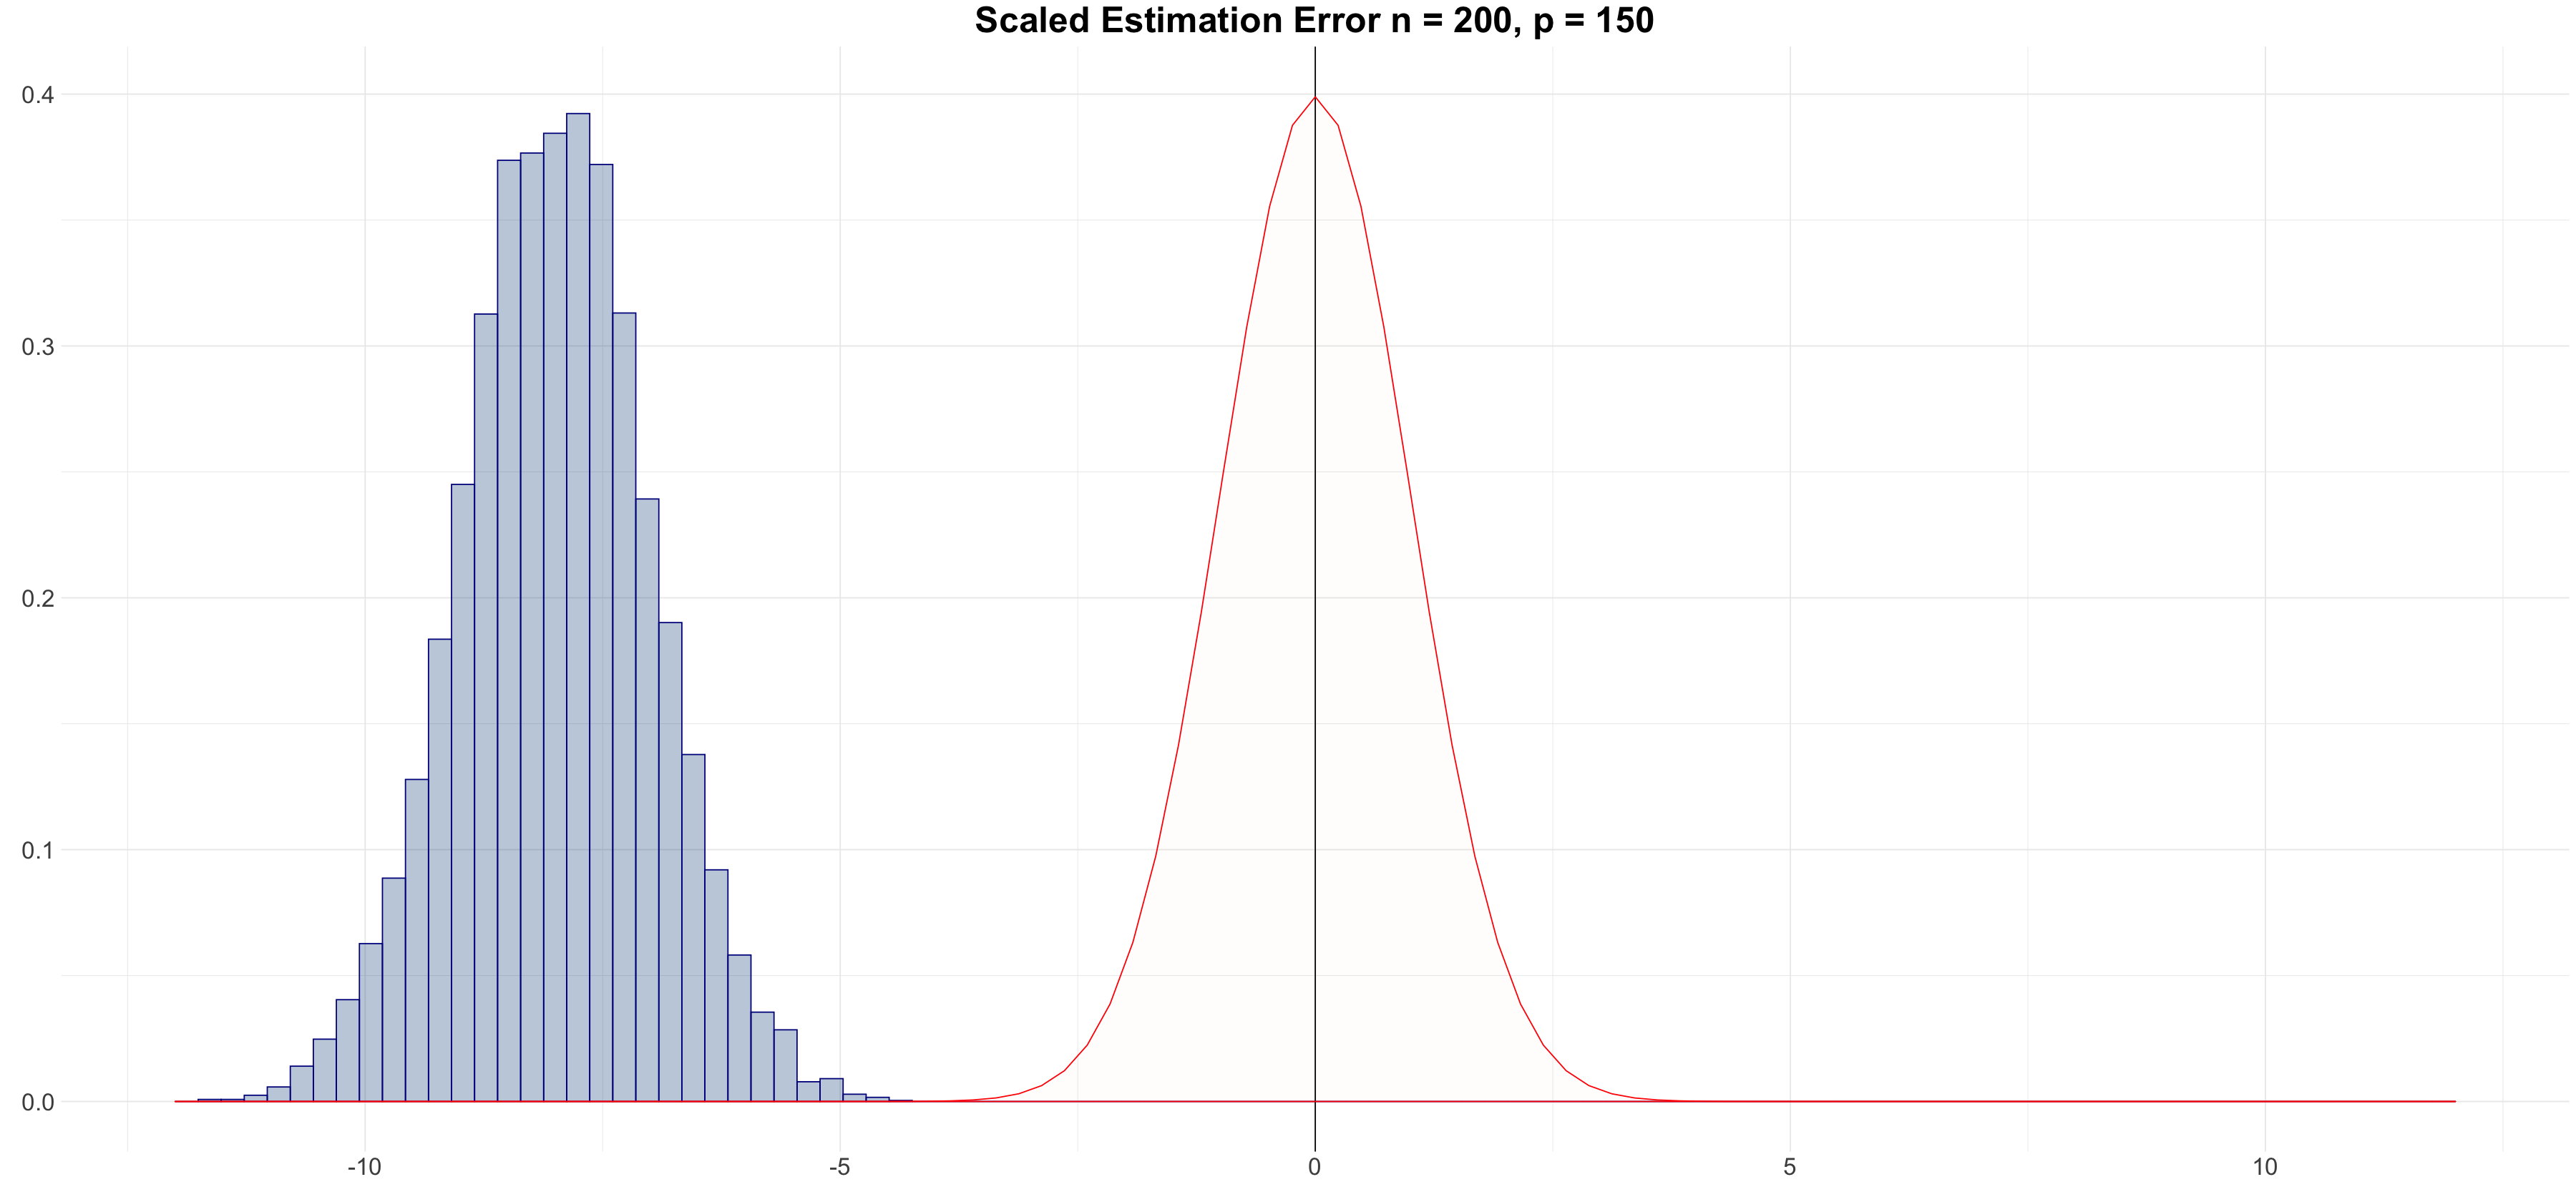

In [127]:
# Plotting the results as a scaled estimation error: significant bias
df_naive = data.frame(theta_hat_naive = theta_hat_naive - theta)
sd_naive = sd(theta_hat_naive)

df_naive_scaled = data.frame("theta_hat_naive" = df_naive$theta_hat_naive/sd_naive)

fig1 = ggplot(df_naive_scaled, aes(x = theta_hat_naive)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-12, 12)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig1

### 2a) DML Estimator without cross-fitting - Figure 2a

In [128]:
no_cross_fx <- function(iteration) {
    
    data = generate_DGP(theta=theta, n_obs=n_obs, dim_x=n_vars, seed=iteration) 
    DML_data <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat   <- learner$clone()                                
    m_hat   <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(DML_data, g_hat, m_hat, n_folds = 1, score='IV-type', apply_cross_fitting=FALSE) 
    DML_PLR$fit() 
    theta_hat <- DML_PLR$coef                           
    return(theta_hat) 
}

theta_hat_orth_nosplit  <- mclapply(1:n_rep, no_cross_fx, mc.set.seed = TRUE, mc.cores = numCores)
theta_hat_orth_nosplit  <- do.call(rbind, theta_hat_orth_nosplit)

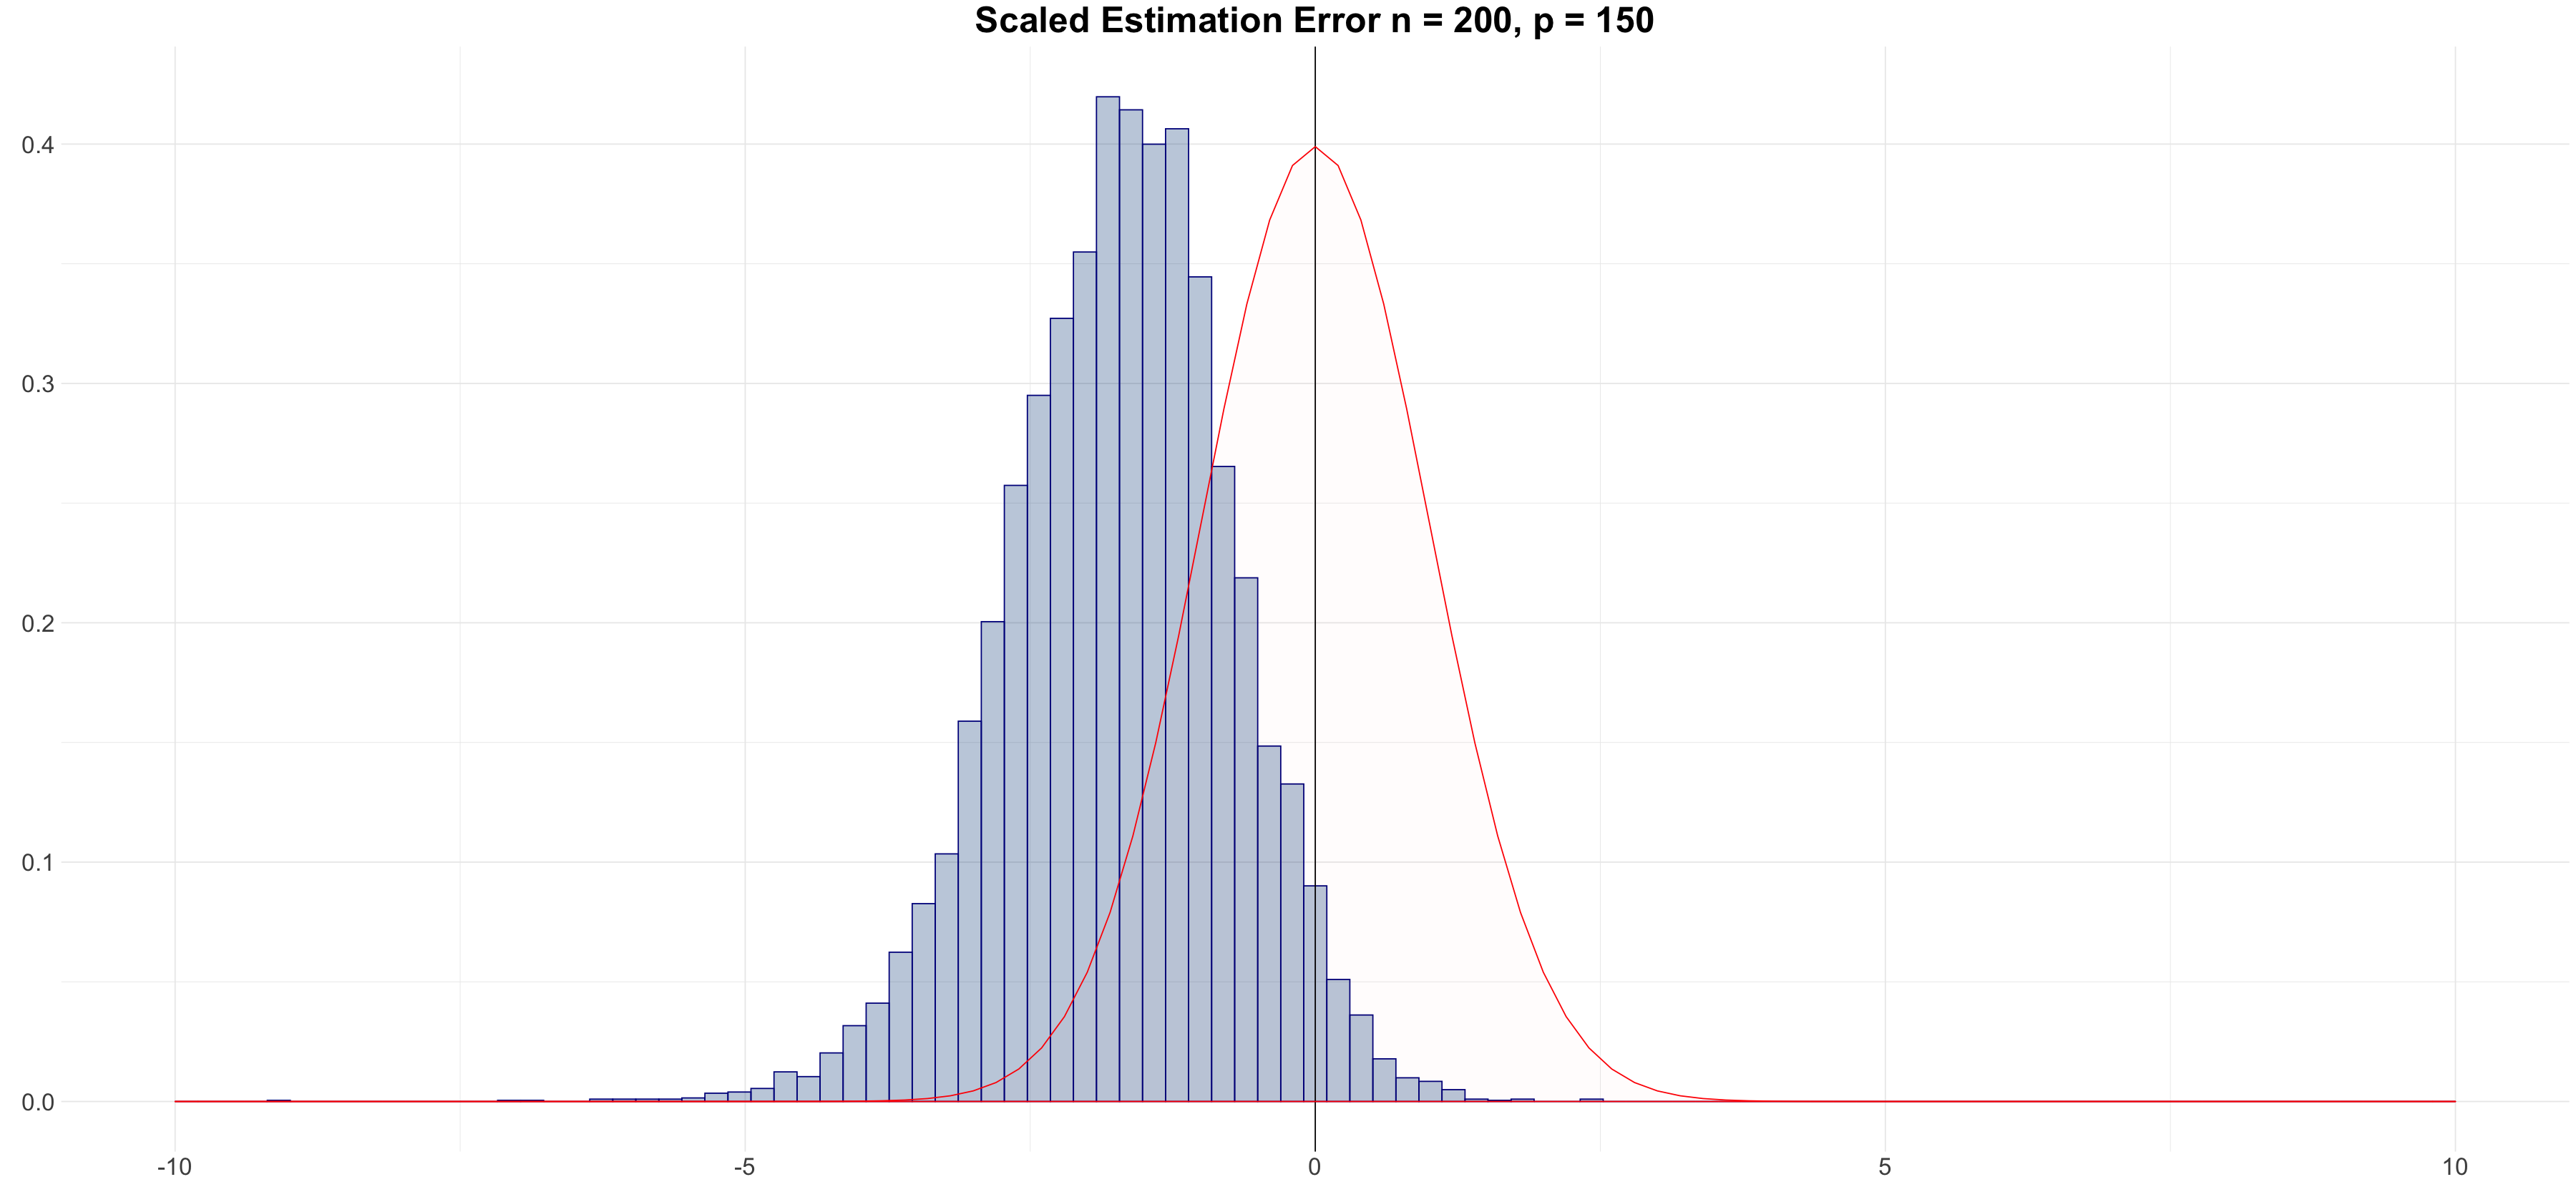

In [129]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
df_nosplit = data.frame(theta_hat_orth_nosplit = theta_hat_orth_nosplit - theta)
sd_nosplit = sd(theta_hat_orth_nosplit)

df_nosplit = data.frame("theta_hat_orth_nosplit" = df_nosplit$d/sd_nosplit)

fig2a = ggplot(df_nosplit, aes(x = theta_hat_orth_nosplit)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig2a

### 2b) DML Estimator with cross-fitting - Figure 2b

In [130]:
boot_fx <- function(iteration) {
    data = generate_DGP(theta=theta,n_obs=n_obs,dim_x=n_vars,seed=iteration) # use default DGP provided in packages (chernozhukov 2018)
    theta_estim <- sim_function(data)[1]  
    return(theta_estim) 
}

theta_hat_orth_split <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
theta_hat_orth_split <- do.call(rbind, theta_hat_orth_split)

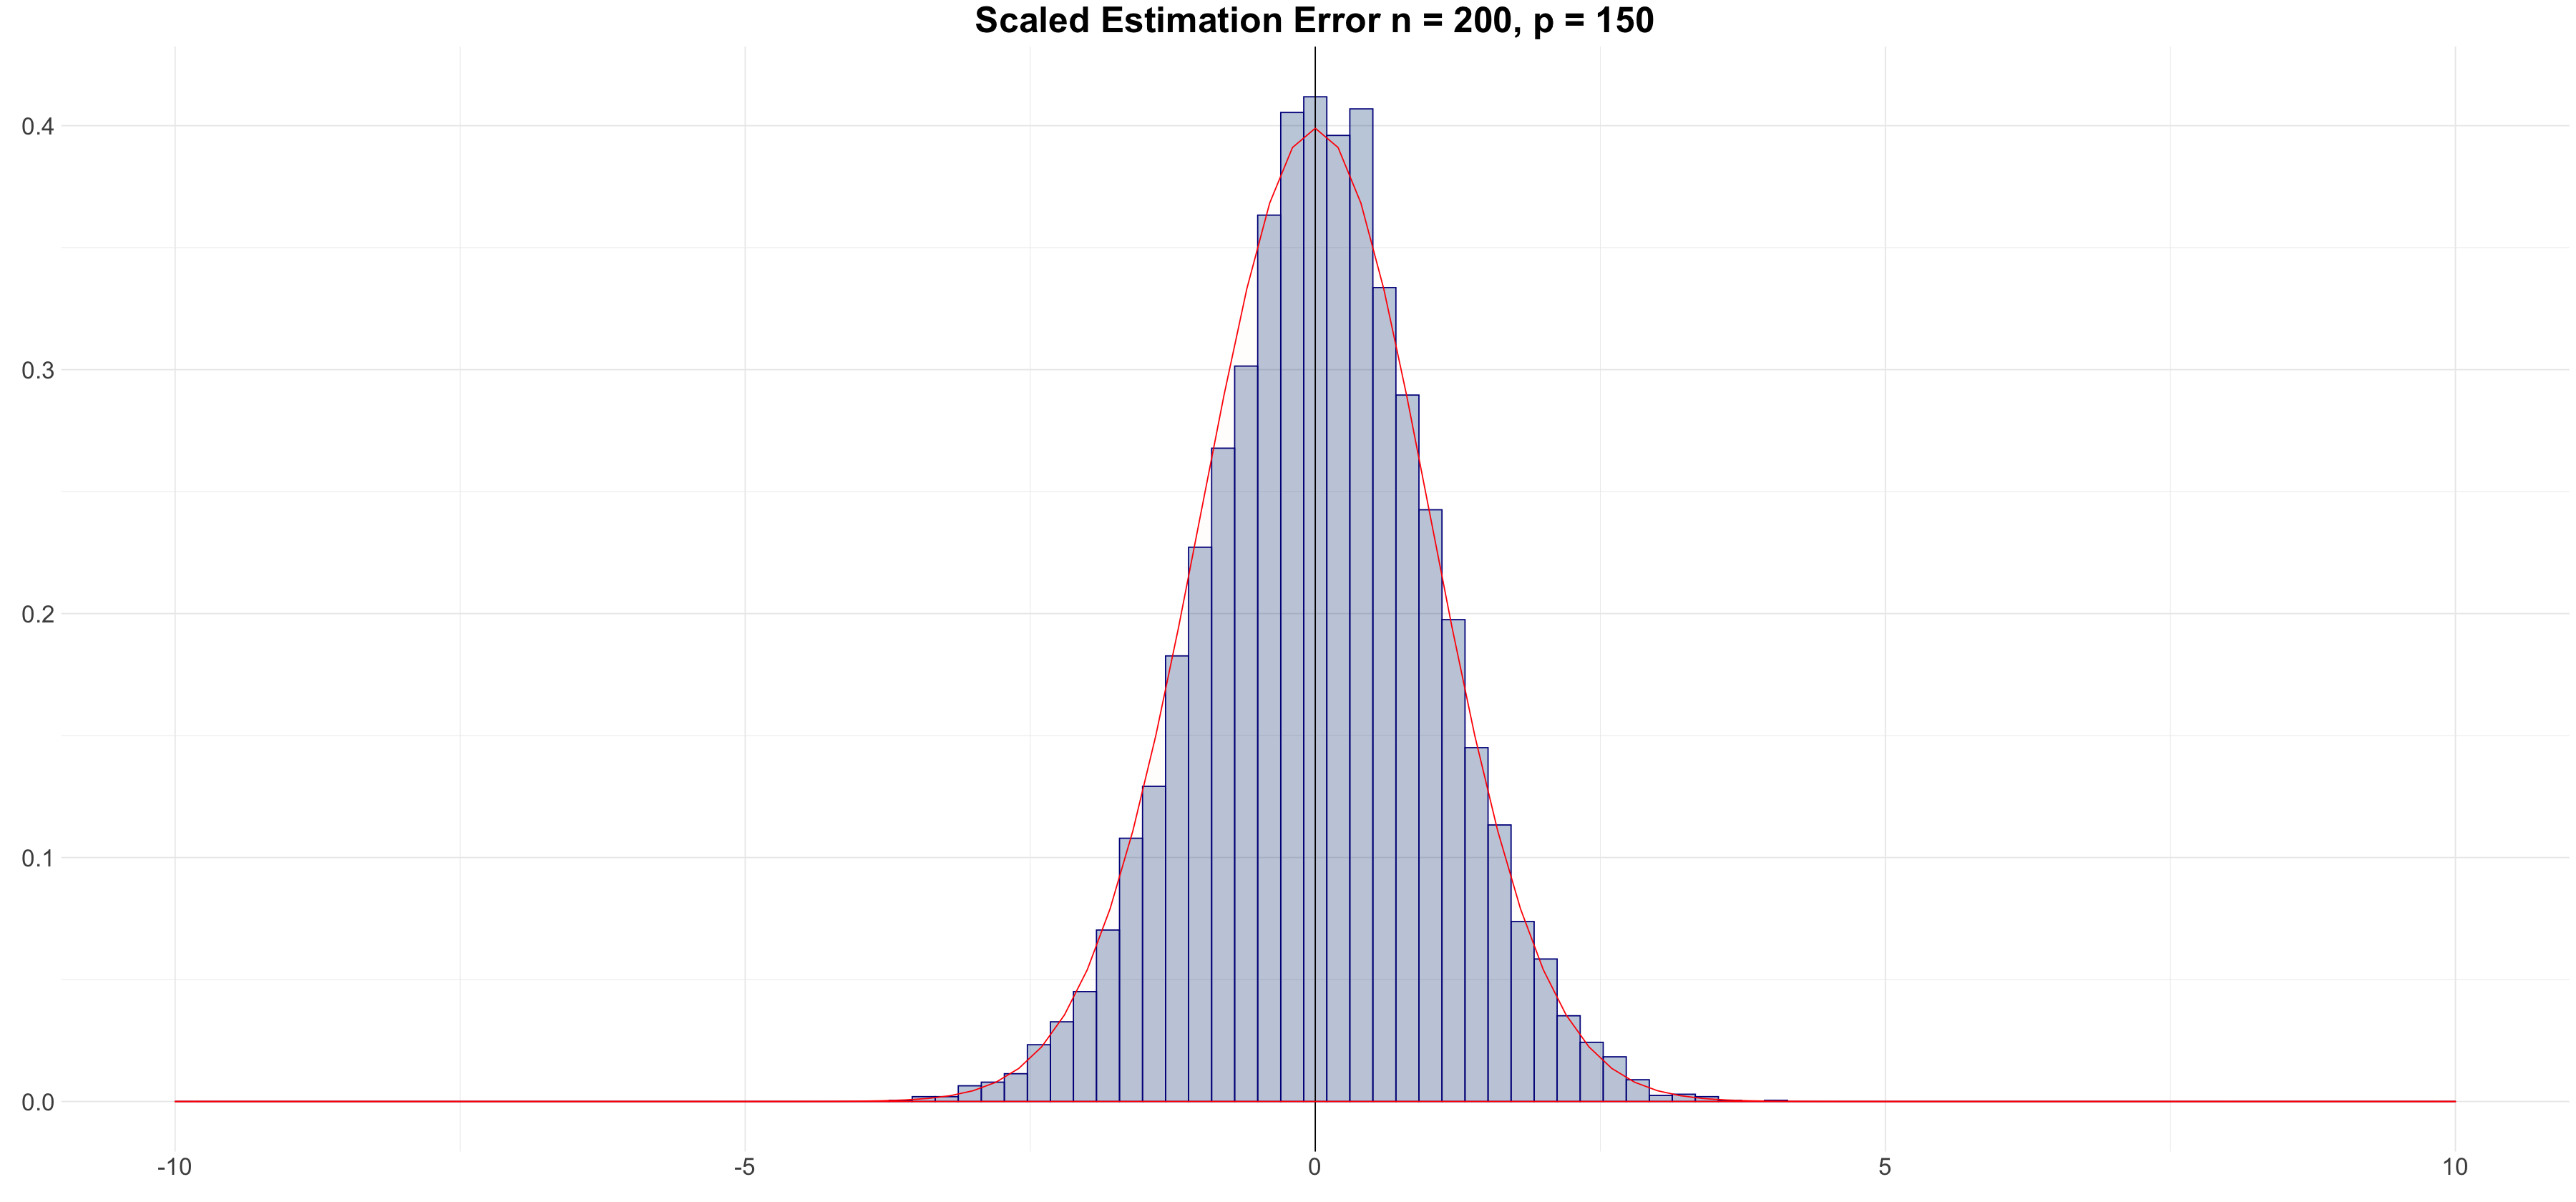

In [131]:
# Plotting the distribution of scaled estimation for DML with cross-fitting
df_split = data.frame('theta_hat_orth_split' = theta_hat_orth_split - theta)
sd_split = sd(theta_hat_orth_split)

df_split = data.frame("theta_hat_orth_split" = df_split/sd_split)

fig2b = ggplot(df_split, aes(x = theta_hat_orth_split)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig2b

### 3a) DML Estimator with M-bias control in dataset - Figure 3a

In [165]:
n_con = 1

boot_fx <- function(iteration) {
        
    data = confounded_DGP(theta=theta,n_obs=n_obs,dim_x=n_vars,seed=iteration,n_con=n_con) # use default DGP provided in packages (chernozhukov 2018)
    theta_estim <- sim_function(data)[1]  
    return(theta_estim) 
}

all_estimates_confound  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_confound <- do.call(rbind, all_estimates_confound)

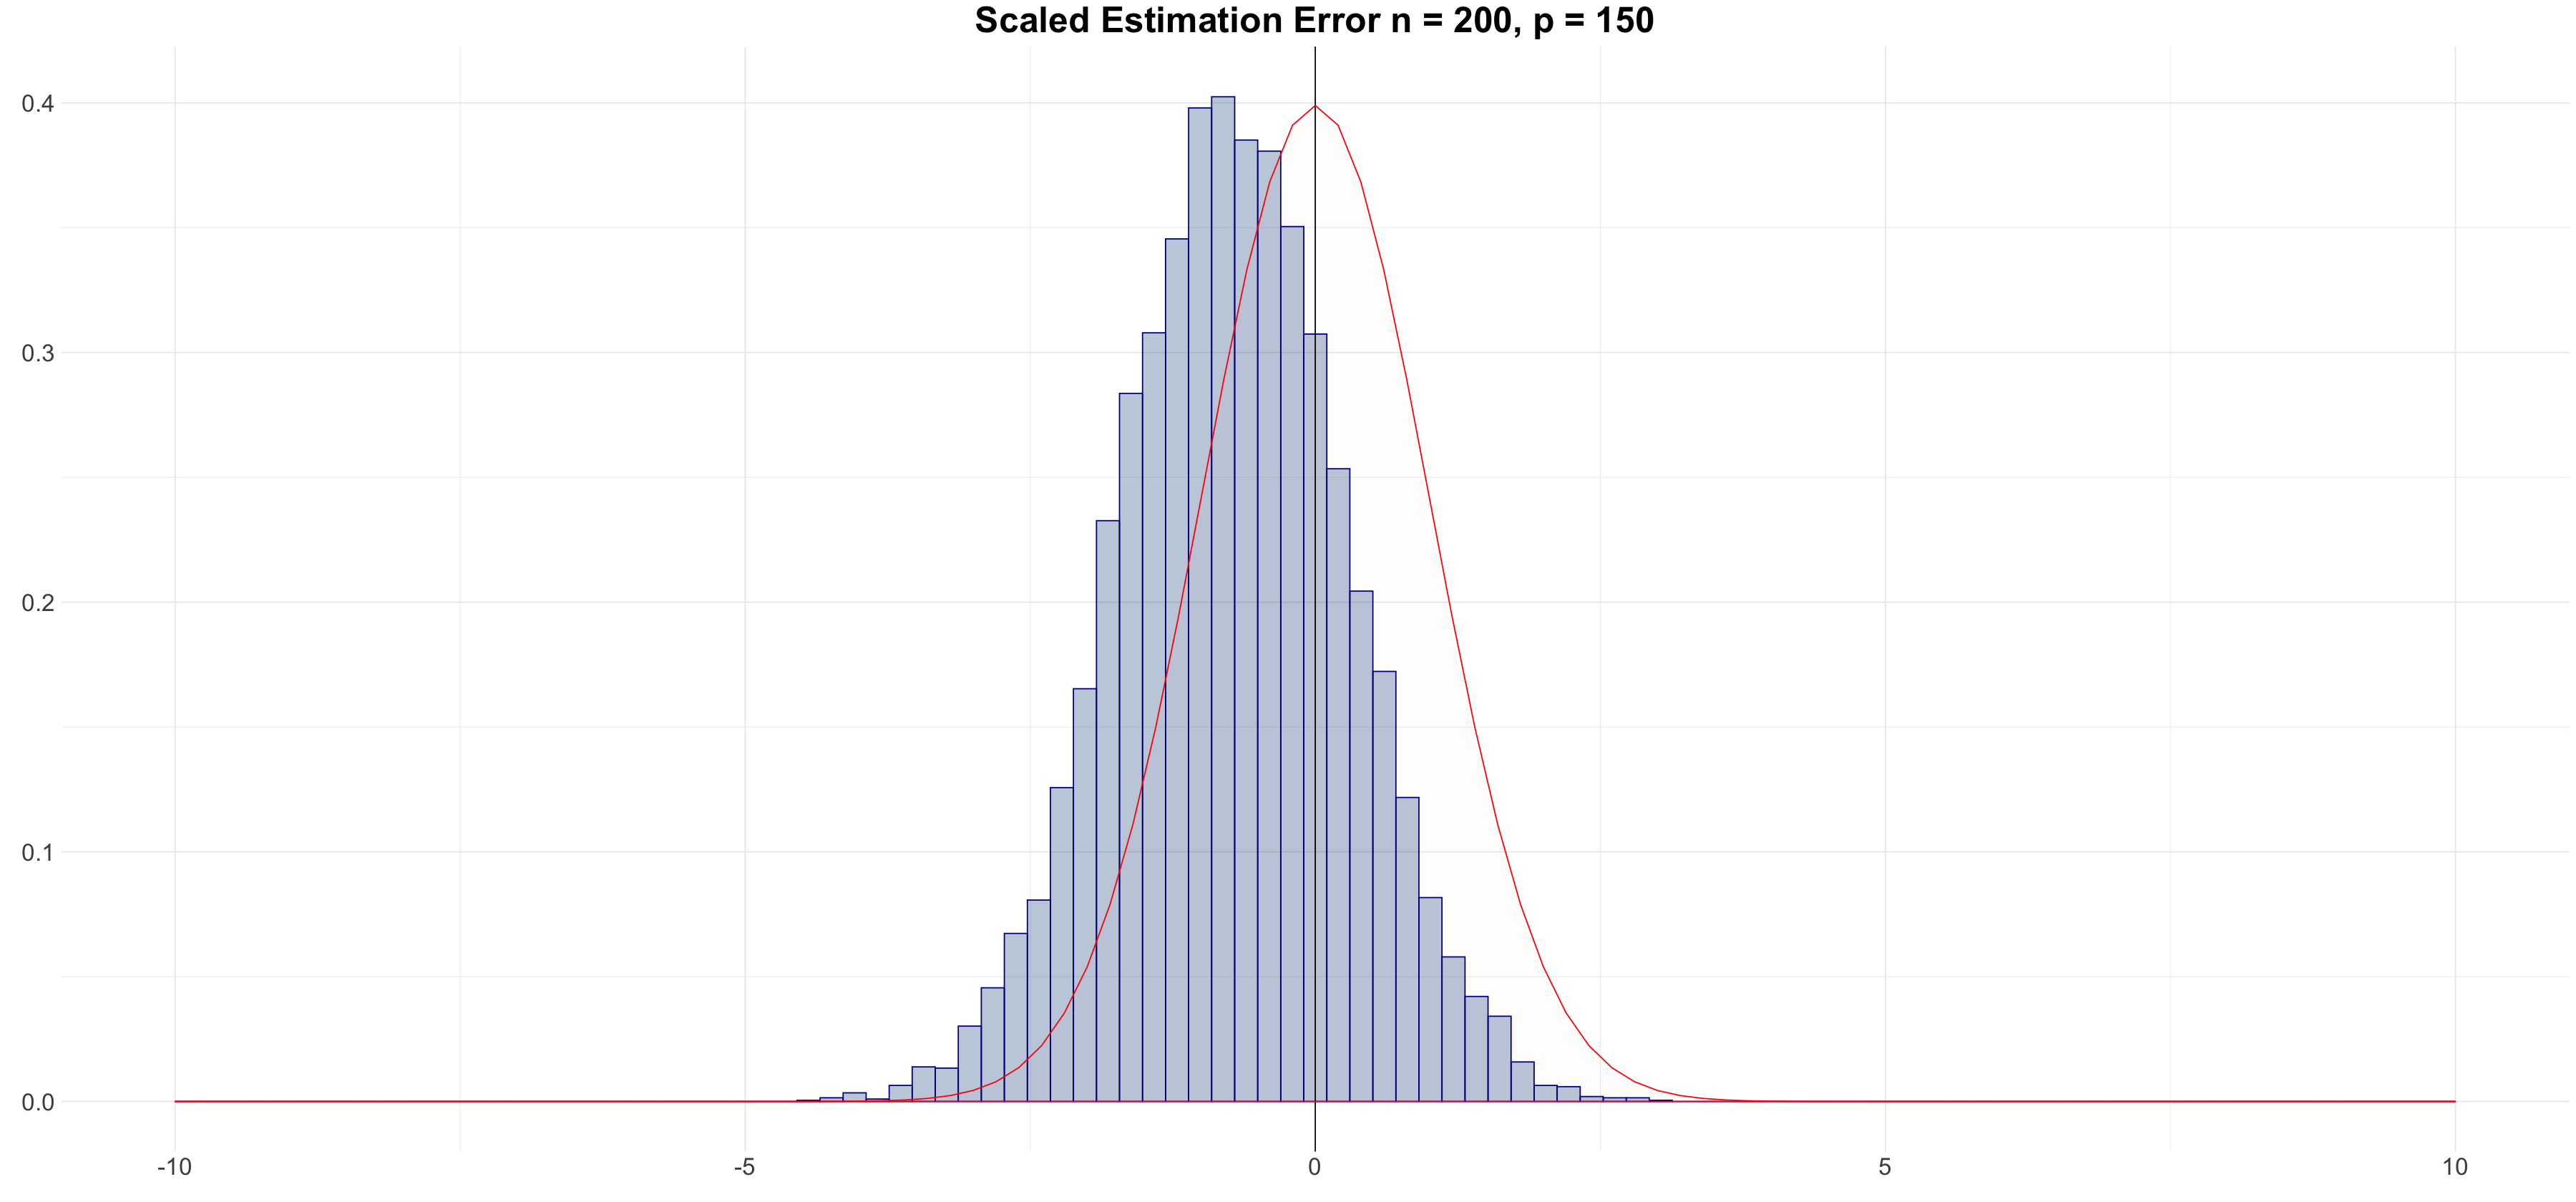

In [166]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
theta_hat_confound <- all_estimates_confound
df_confound = data.frame(theta_hat_confound = theta_hat_confound - theta)
sd_confound = sd(theta_hat_confound)

df_confound_scaled = data.frame("theta_hat_confound" = df_confound/sd_confound)

fig3a = ggplot(df_confound_scaled, aes(x = theta_hat_confound)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig3a

### 3b) DML Estimator without M-bias control in dataset - Figure 3b

In [167]:
n_con = 0

boot_fx <- function(iteration) {
        
    data = confounded_DGP(theta=theta,n_obs=n_obs,dim_x=n_vars,seed=iteration,n_con=n_con) # use default DGP provided in packages (chernozhukov 2018)
    theta_estim <- sim_function(data)[1]  
    return(theta_estim)  
}

all_estimates_no_confound  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_no_confound <- do.call(rbind, all_estimates_no_confound)

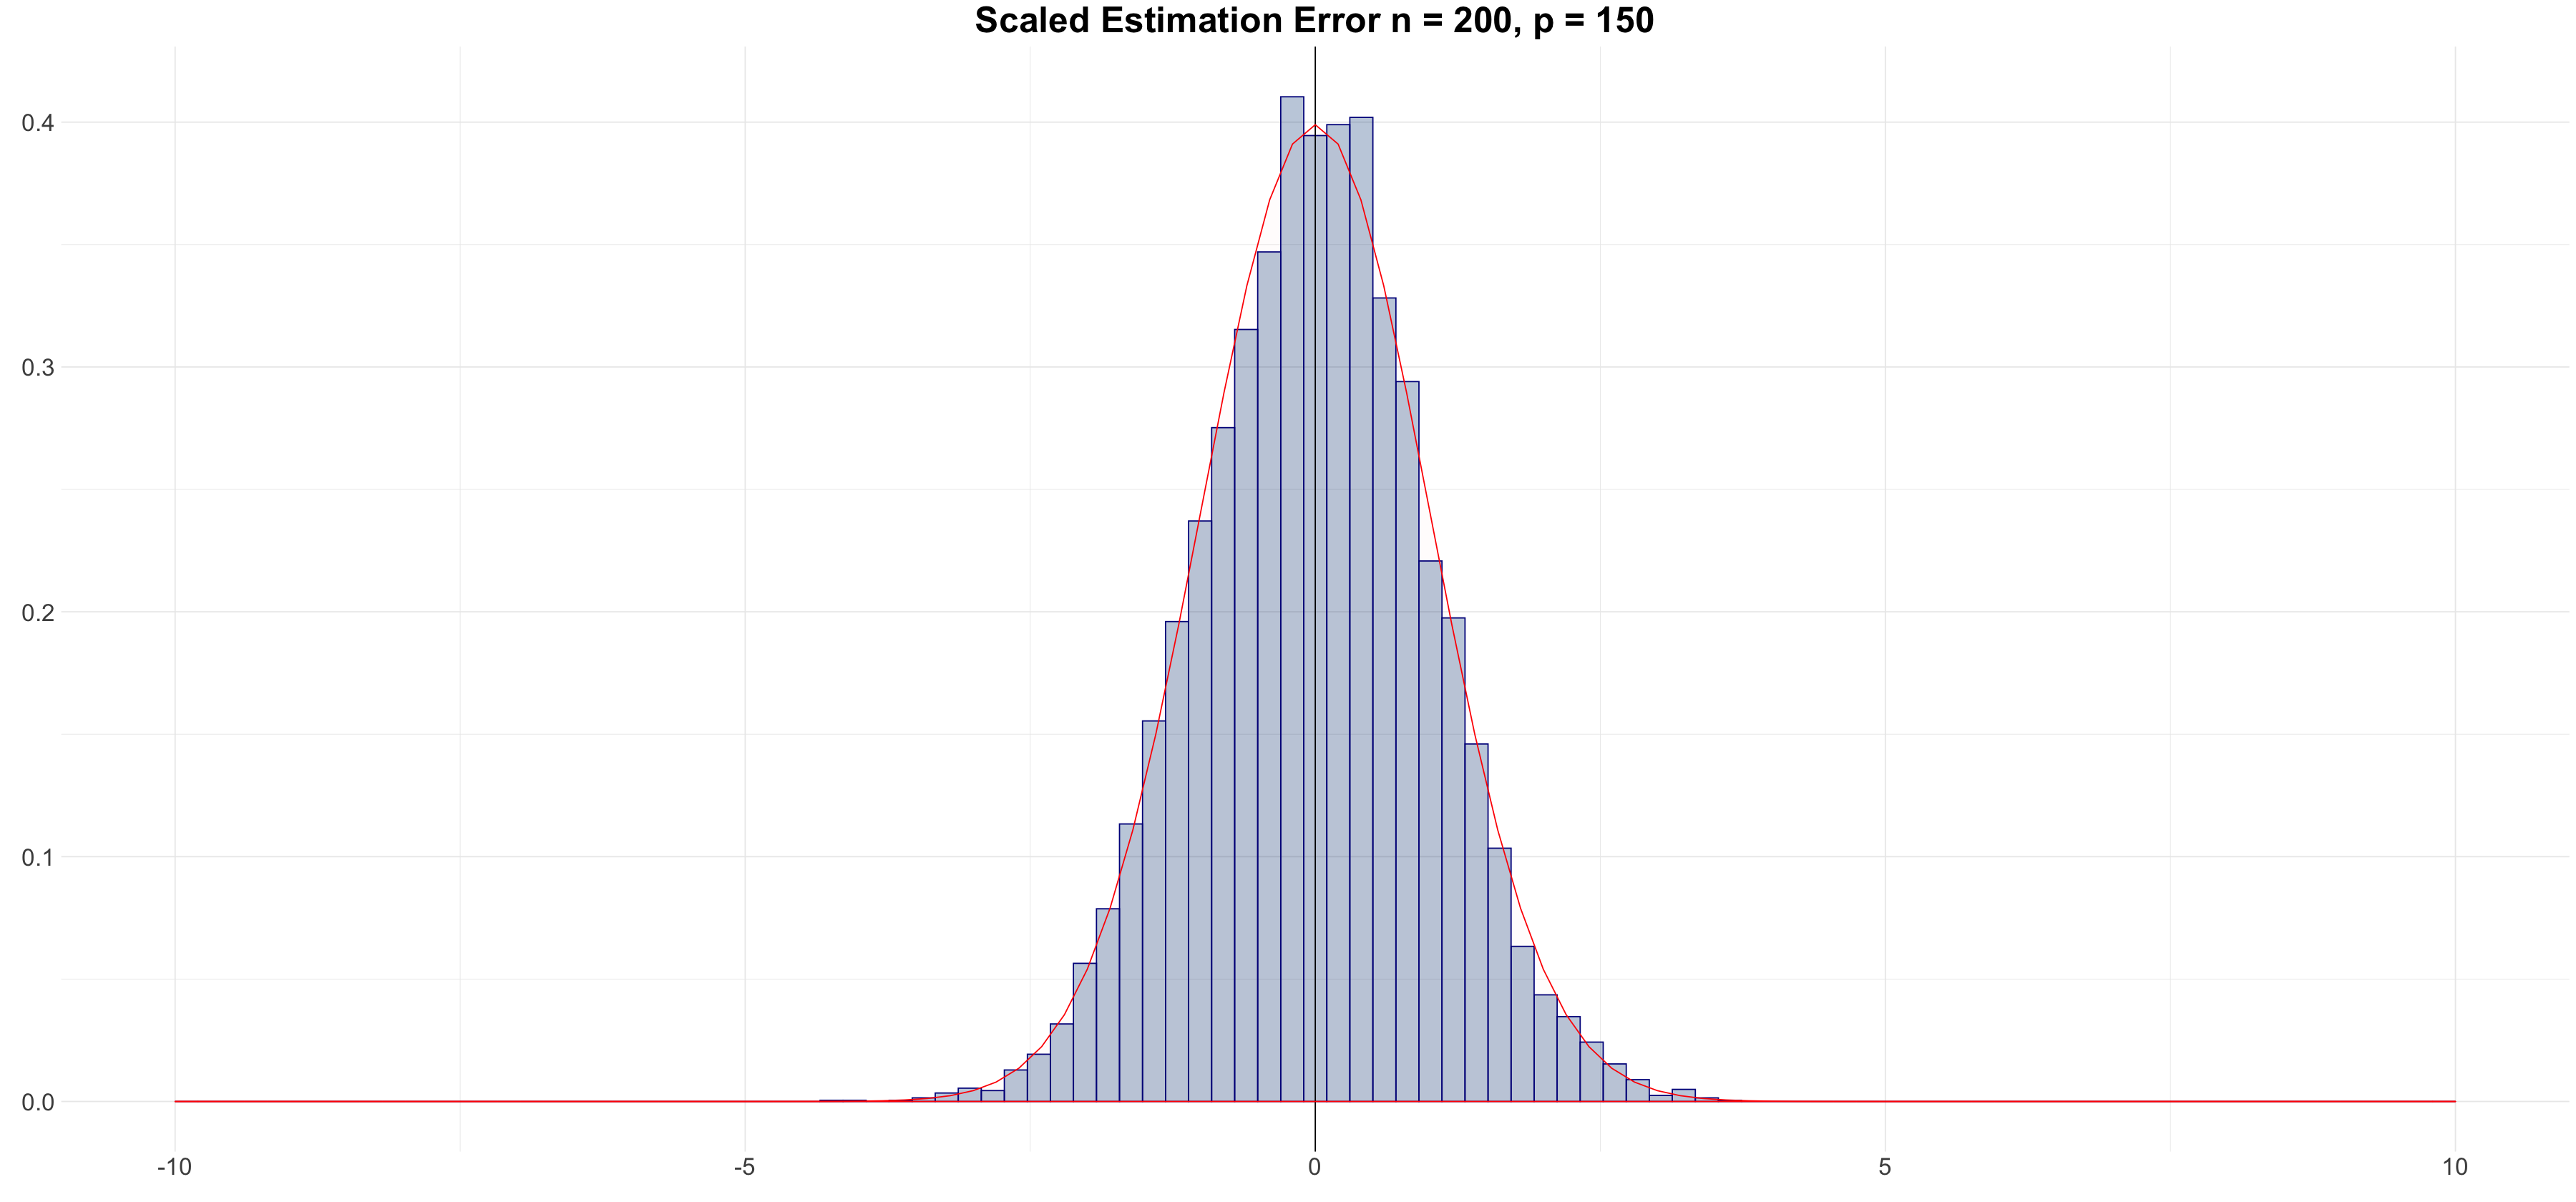

In [168]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
theta_hat_no_confound <- all_estimates_no_confound
df_no_confound = data.frame(theta_hat_no_confound = theta_hat_no_confound - theta)
sd_no_confound = sd(theta_hat_no_confound)

df_no_confound_scaled = data.frame("theta_hat_no_confound" = df_no_confound/sd_no_confound)

fig3b = ggplot(df_no_confound_scaled, aes(x = theta_hat_no_confound)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig3b

### 4) DML Estimator in an empirically motivated simulation

In [4]:
X_data <- data_unconfound[,c('lths','scol','cold','sp_lths','sp_scol','sp_cold','sp_imm','chld1',
                  'age','age2','age3','sp_age','sp_age2','sp_age3','yrsusa1','yrsusa2',
                  'sp_yrsusa1','sp_yrsusa2','igenfert','ligengdp','igenlfp','igensr','girl_lfp','girl_sr')]

x_data <- as.matrix(X_data[,c('age','age2','age3','sp_age','sp_age2','sp_age3','yrsusa1','yrsusa2',
                  'sp_yrsusa1','sp_yrsusa2','igenfert','ligengdp','igenlfp','igensr','girl_lfp','girl_sr')])

colnames(x_data) <- NULL

In [5]:
empirical_DGP <- function(n_obs,seed,x_means,sigma,p_lths,p_scol,p_cold,p_sp_lths,p_sp_scol,
                         p_sp_cold,p_sp_imm,p_chld1,beta) {
    
    set.seed(seed)
    #multiplicatives in nuisance functions  
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    
    # Continous Variables generated using empirical means and variance-covariance matrix
    # Dummy variables generated using Bernoulli dist with p determined by the asymptotic empirical mean
    x       <- mvrnorm(n = n_obs, x_means, sigma)
    
    x_1 <- rbinom(n_obs,1,p_lths)
    x_2 <- rbinom(n_obs,1,p_scol)
    x_3 <- rbinom(n_obs,1,p_cold)
    x_4 <- rbinom(n_obs,1,p_sp_lths)
    x_5 <- rbinom(n_obs,1,p_sp_scol)
    x_6 <- rbinom(n_obs,1,p_sp_cold)
    x_7 <- rbinom(n_obs,1,p_sp_imm)
    x_8 <- rbinom(n_obs,1,p_chld1)
    
    X <- cbind(x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x)
    
    # nuisance paraneter g_0 and outcome y
    y     <- as.matrix(X %*% beta + eps)

    # Data prep
    colnames(X) <- paste0("X", 1:24)
    colnames(y) <- "y"
    data = data.frame(X, y)
    return(data)
} 

In [6]:
# True betas
beta <- c(0.1660668,-0.0983785,-0.2034135,0.0954286,-0.0365834,-0.0552261,-0.1779819,-0.3792859,0.1590419,
         -0.0028934,0.0000121,0.1079551,-0.001921,9.42e-06,0.0552484,-0.0011478,0.0260405,-0.0005214,
         0.1055774,0.109839,-0.0688981,-0.5211407,-0.0815892,0.4130042)

# Bernoulli asymptotic estimated probabilities (means) from Blau et al. 2020
p_lths    <- 0.196818236562907
p_scol    <- 0.208216088379885
p_cold    <- 0.407246011846759
p_sp_lths <- 0.2130007773751
p_sp_scol <- 0.1957561888912
p_sp_cold <- 0.408154774287497
p_sp_imm  <- 0.76248453461509
p_chld1   <- 0.487118566126154

# Empirical Means and Variances
x_means <- colMeans(x_data)
sigma   <- cov(x_data)

In [46]:
n_obs = 200
n_rep = 10000

emp_fx <- function(iteration) {
        
    data <- empirical_DGP(n_obs,seed=iteration,x_means,sigma,p_lths,p_scol,p_cold,p_sp_lths,
                         p_sp_scol,p_sp_cold,p_sp_imm,p_chld1,beta) 
    DML_data     <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "X19")
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  # use LASSO to estimate nuisance g() and m()
    m_hat <- learner$clone()

    DML_PLR  <- DoubleMLPLR$new(DML_data, g_hat, m_hat)   # initialize the DML Partially Linear Model 
    DML_PLR$fit()                                             # Fit the model and extract coefficient estimates
    theta_estim  <- DML_PLR$coef
    return(theta_estim) 
}

all_estimates_emp  <- mclapply(1:n_rep, emp_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_emp <- do.call(rbind, all_estimates_emp)

In [48]:
theta = 0.1055774
n_vars = 24

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


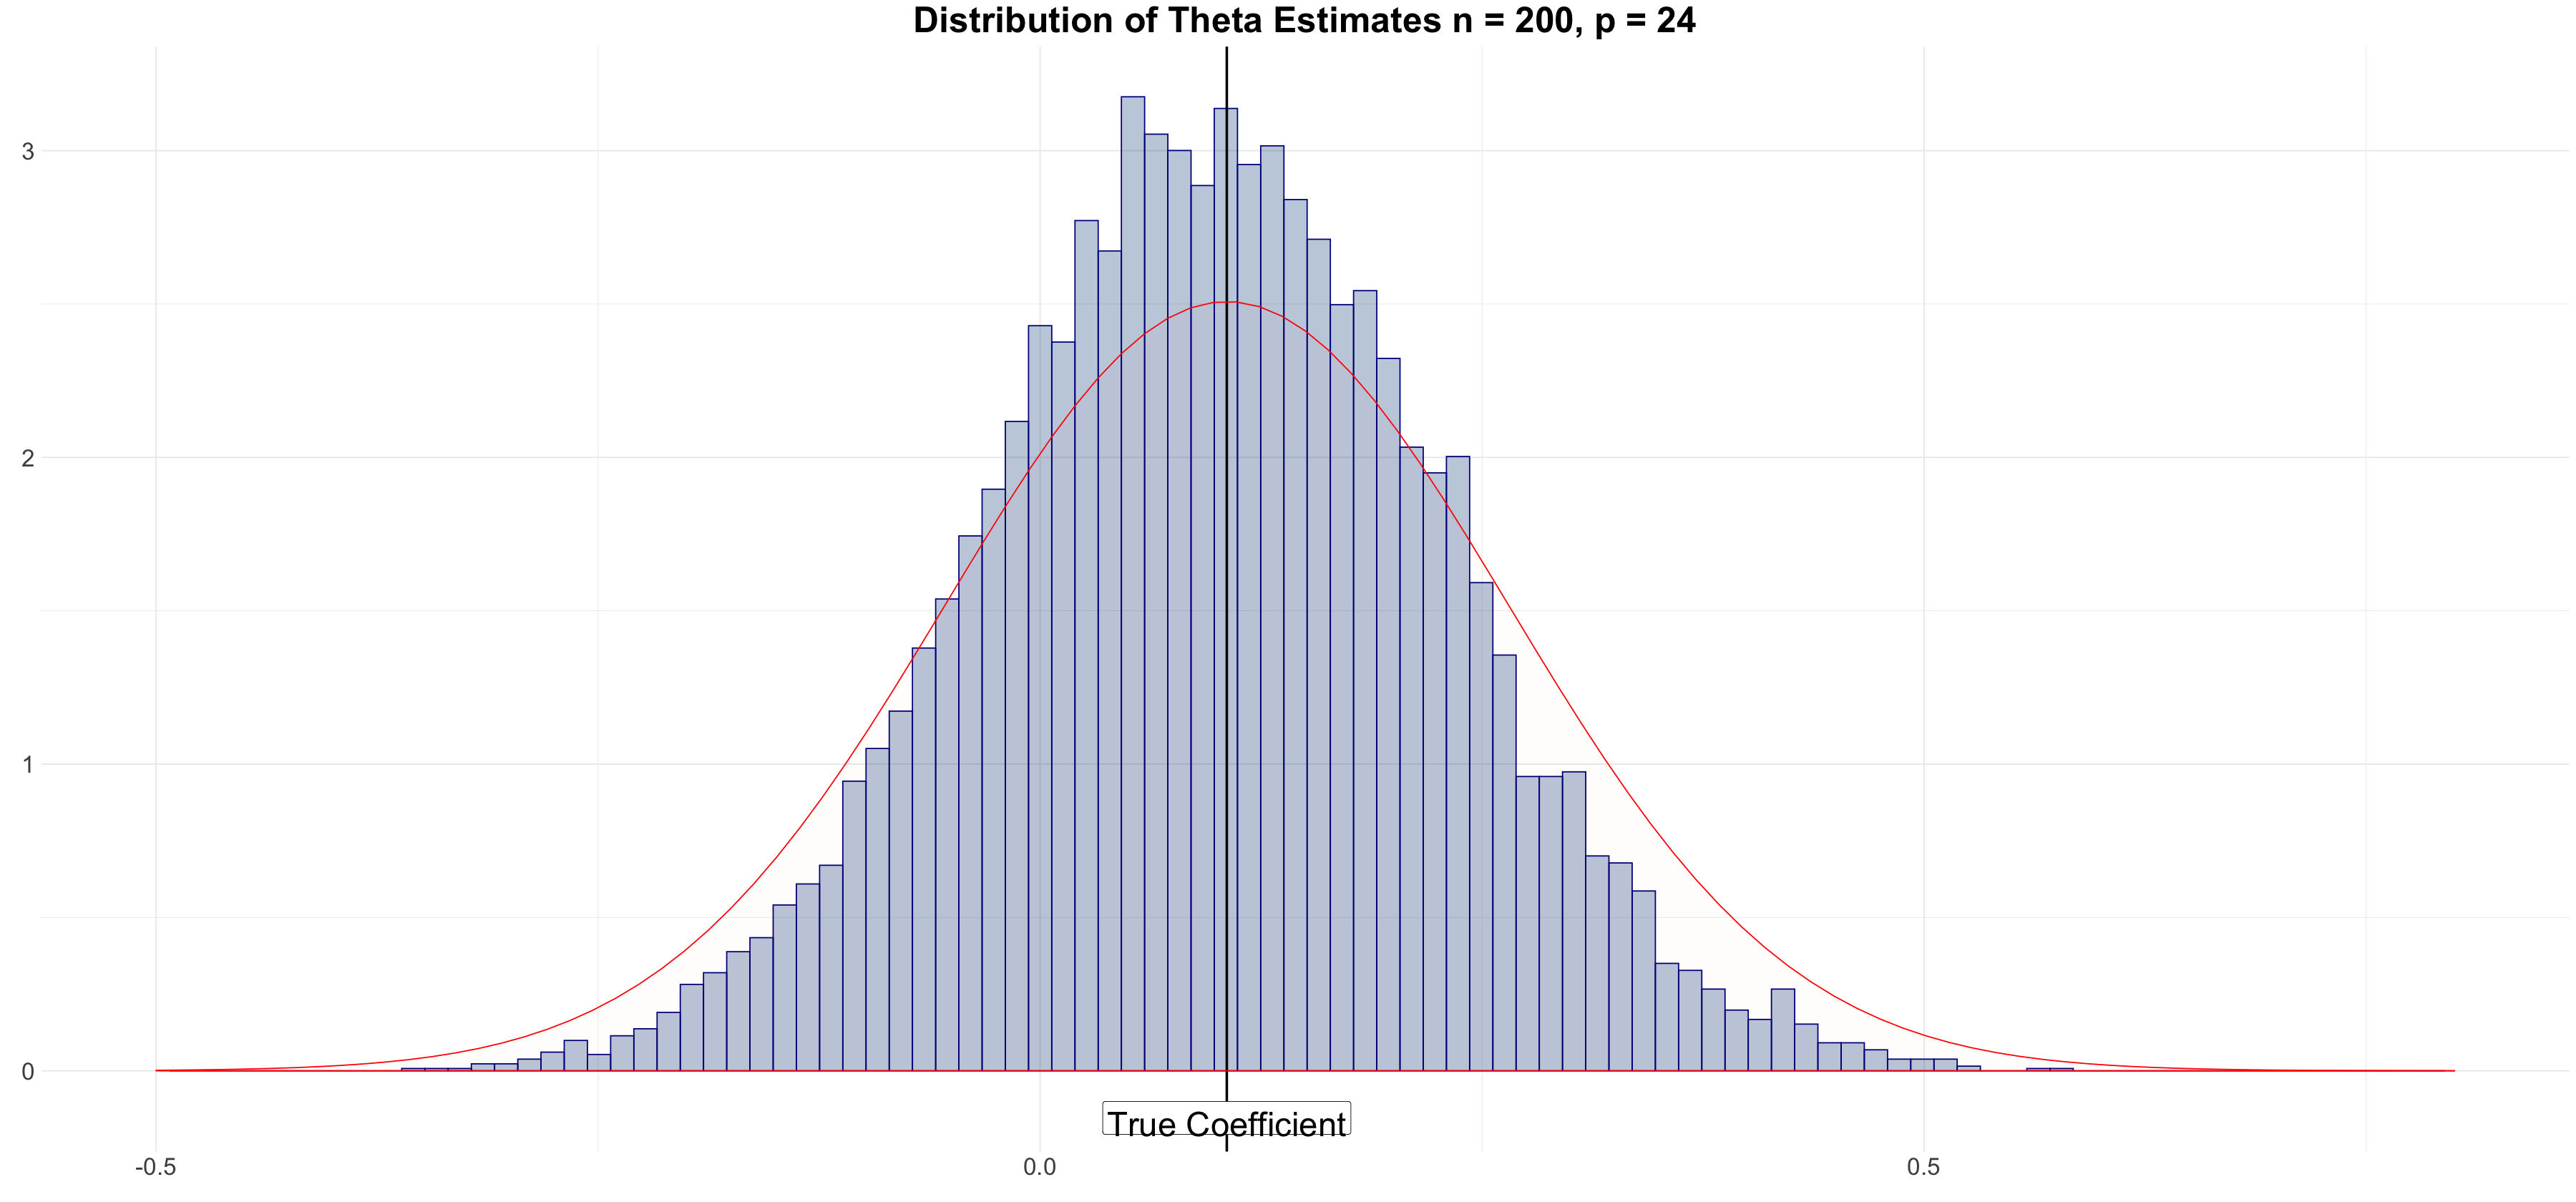

In [118]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
theta_hat_emp <- all_estimates_emp
df_emp = data.frame(all_estimates_emp = all_estimates_emp)

fig4 = ggplot(df_emp, aes(x = all_estimates_emp)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = theta), col = "black",size=1) +
        annotate(x=theta,y=-0.1,label="True Coefficient",vjust=1,size=10,geom="label") +
        xlab("") + ylab("") + theme_minimal() +  xlim(c(-0.5, 0.8)) +
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = theta, sd = sqrt(0.0252998)), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Distribution of Theta Estimates n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig4

### 5) DML Finite Sample Sensitivity to k-Fold Sample Splitting

In [140]:
# LASSO Estimation Function with different folds
est_lasso_kfolds <- function(obj_dml_data) {
    
    set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  
    m_hat <- learner$clone()
    
    DML_PLR4  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=4)   
    DML_PLR4$fit()                                            
    theta_4 <- DML_PLR4$coef
    
    DML_PLR5  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=5)   
    DML_PLR5$fit()                                            
    theta_5 <- DML_PLR5$coef
    
    DML_PLR6  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=6)   
    DML_PLR6$fit()                                            
    theta_6 <- DML_PLR6$coef
    
    DML_PLR8  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=8)   
    DML_PLR8$fit()                                            
    theta_8 <- DML_PLR8$coef
          
    DML_PLR10  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=10)   
    DML_PLR10$fit()                                            
    theta_10 <- DML_PLR10$coef

    theta_estims    <- cbind(theta_4,theta_5,theta_6,theta_8,theta_10)
    return(theta_estims)
}

In [141]:
# Simulation function: Take in generate_data, spit out estimates for theta coef and sd
sim_function <- function(data){
    
    DML_data    <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    coef_output <- est_lasso_kfolds(DML_data) 
    return(coef_output)
}

In [142]:
### Fixed Design Parameters
n_rep  = 100
n_vars = 200
theta  = 1

# Varied k and sample size
sample_size <- seq(30, 300, by = 10)

iterations = vector("list",length(sample_size))

for (i in 1:length(sample_size)) {
    
    boot_fx <- function(iteration) {        
        data        <- turrell_DGP(n_obs=sample_size[i],dim_x=n_vars,theta,seed=iteration)
        theta_estim <- sim_function(data) 
        return(theta_estim) 
    }
    
    parallel_estims <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    iterations[[i]] <- do.call(rbind, parallel_estims)

}


In [143]:
# Matrices to store results and calculate bias, variance, MSE
bias_matrix <- matrix(NA, ncol = dim(iterations[[1]])[2], nrow = length(sample_size))
var_matrix  <- matrix(NA, ncol = dim(iterations[[1]])[2], nrow = length(sample_size))
mse_matrix  <- matrix(NA, ncol = dim(iterations[[1]])[2], nrow = length(sample_size))
box_errors  <- matrix(NA, ncol = length(sample_size), nrow = n_rep)    # for boxplot

for (i in 1:length(sample_size)) {
    bias_matrix[i,] <- (colMeans(iterations[[i]]) - 1)
    var_matrix[i,]  <- apply(iterations[[i]], 2, var)
    box_errors[,i] <- iterations[[i]][,2]
}

mse_matrix <- (bias_matrix)^2 + (var_matrix)

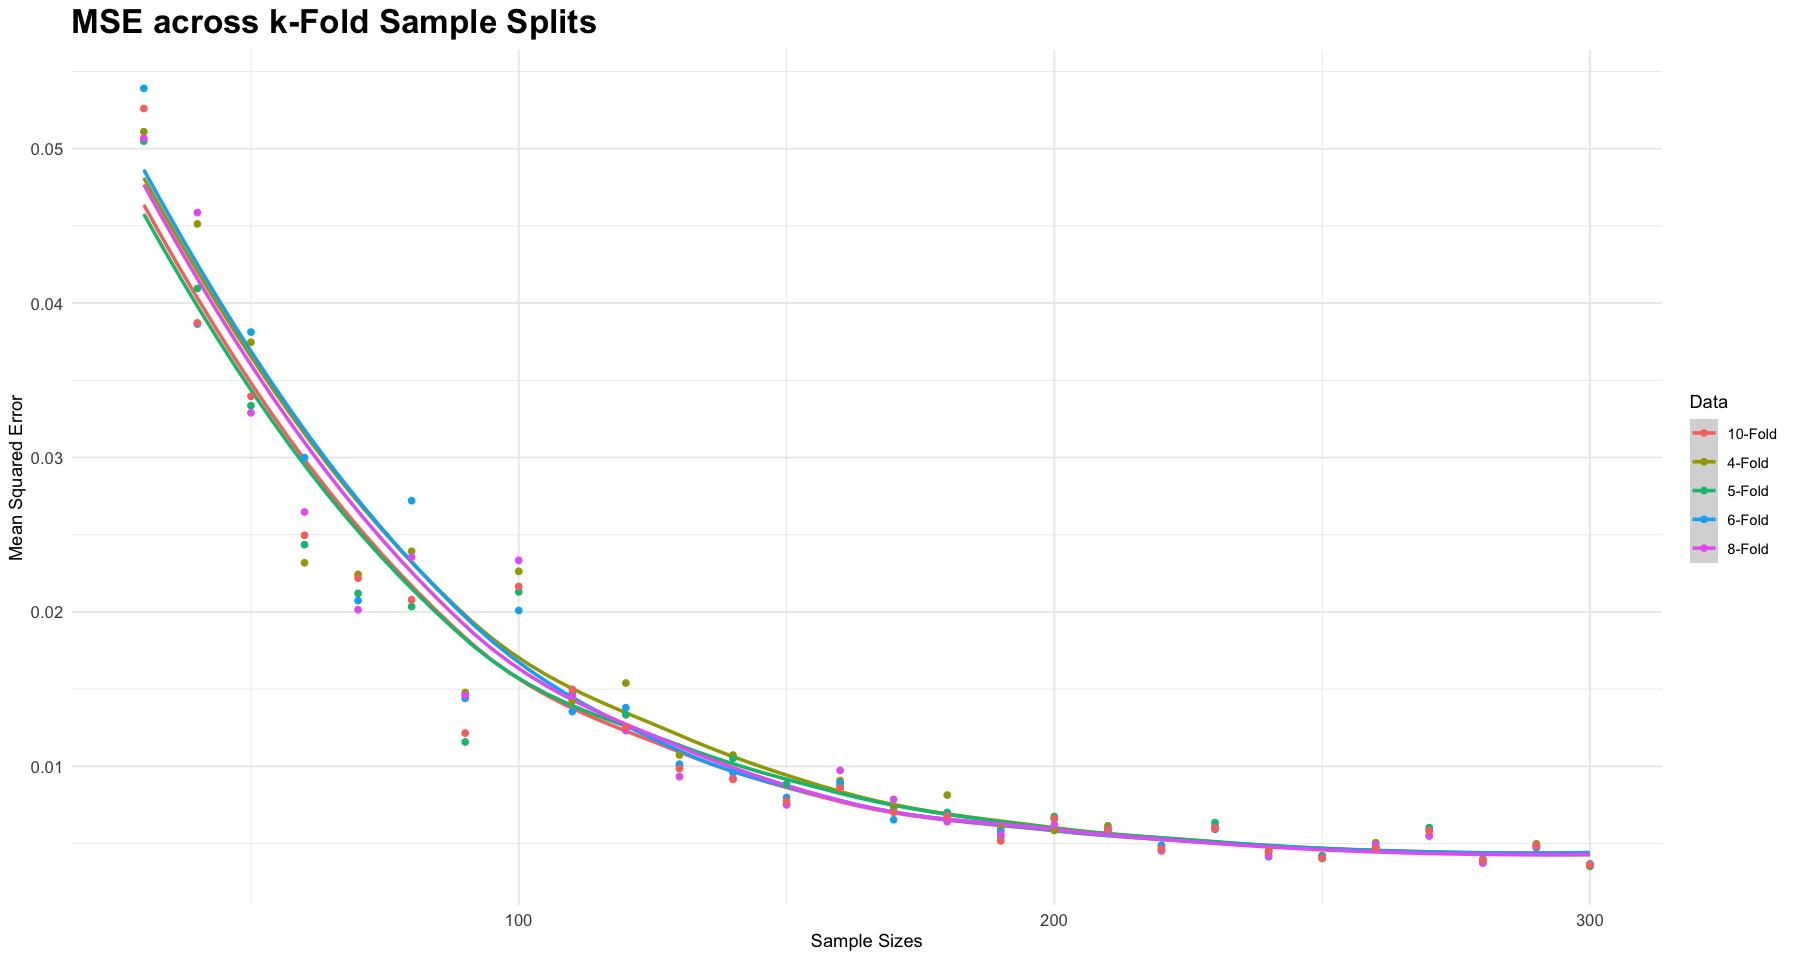

In [146]:
# All the result are organized in a trade-off matrix which will be used to plot graphs
df_tradeoff <- data.frame(c(rep("4-Fold",length(sample_size)),
                            rep("5-Fold",length(sample_size)),
                            rep("6-Fold",length(sample_size)),
                            rep("8-Fold",length(sample_size)),
                            rep("10-Fold",length(sample_size))),
    c(mse_matrix[,1],mse_matrix[,2],mse_matrix[,3],
     mse_matrix[,4],mse_matrix[,5]),rep(sample_size,dim(iterations[[1]])[2]))
colnames(df_tradeoff)<-c("Data","MSE","SampleSize")

# Plot the MSE against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=MSE, group=Data, colour=Data)) + 
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + xlab("Sample Sizes") + ylab("Mean Squared Error") + theme_minimal() +
    #coord_cartesian(ylim=c(0.0,0.058)) +
    theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=10)) +
    ggtitle("MSE across k-Fold Sample Splits") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)


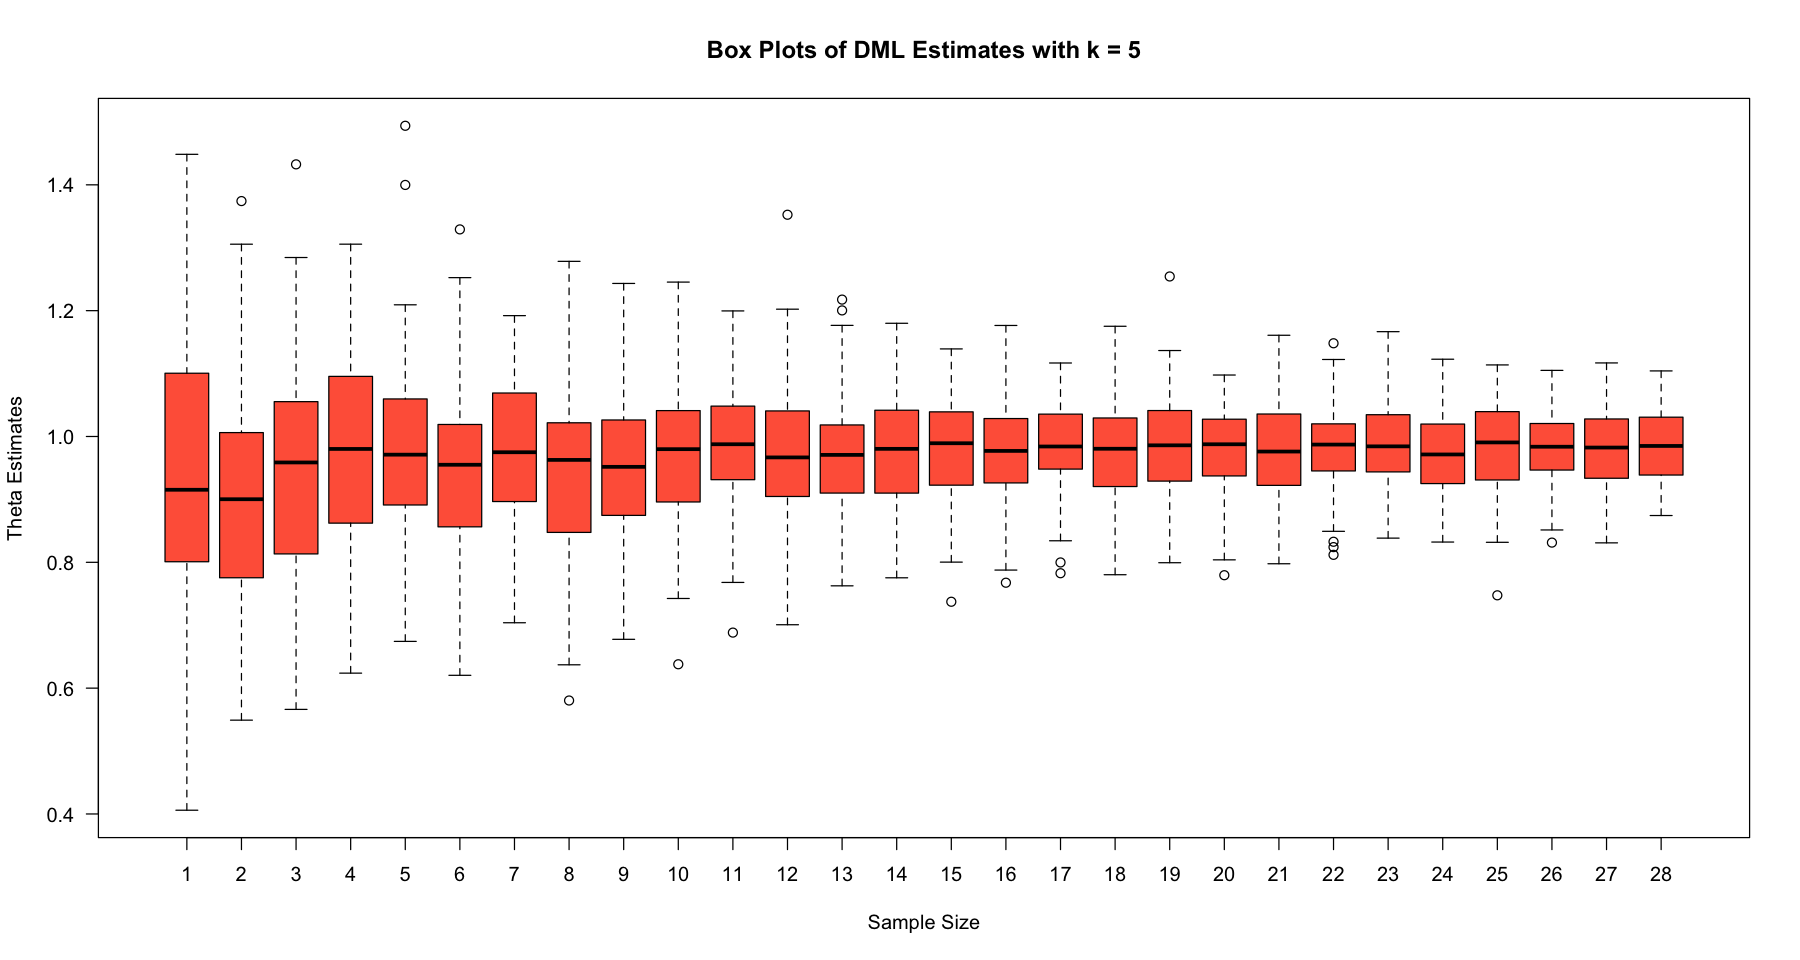

In [145]:
# Appendix Figure
boxplot(box_errors,
        main = "Box Plots of DML Estimates with k = 5",
        ylab = "Theta Estimates",
        xlab = "Sample Size",
        col = "tomato", las = 1)

---
## Part 2: Empirical Application
---

### I: Son Preferences in the United States (Blau et al., 2020)

In [169]:
# Importing control variables used for all dependant variables for Table 3 Column 3
dataset <- read_excel("blau_data.xlsx")

# ALl variables used in Blau et al. (2020) Table 3, Column (3) Regression
data_unconfound <- data.table(dataset[,c("nchild","lths","scol","cold","sp_lths","sp_scol","sp_cold",
                                         "genrace","sp_genrace","region","year","age","age2","age3",
                                         "sp_age","sp_age2","sp_age3","sp_imm","yrsusa1","yrsusa2",
                                         "sp_yrsusa1","sp_yrsusa2","igenfert","ligengdp","igenlfp",
                                         "igensr","chld1","girl_lfp","girl_sr")])

# Addition of endogenous control for mother's age at first birth: "birthage"
data_confound   <- data.table(dataset[,c("nchild","lths","scol","cold","sp_lths","sp_scol","sp_cold",
                                         "genrace","sp_genrace","region","year","age","age2","age3",
                                         "sp_age","sp_age2","sp_age3","sp_imm","yrsusa1","yrsusa2",
                                         "sp_yrsusa1","sp_yrsusa2","igenfert","ligengdp","igenlfp",
                                         "igensr","chld1","girl_lfp","girl_sr","birthage")])

DML_data_uc  <- double_ml_data_from_data_frame(data_unconfound, y_col = "nchild", d_cols = "igenfert")
DML_data_c   <- double_ml_data_from_data_frame(data_confound, y_col = "nchild", d_cols = "igenfert")

set.seed(12)

In [170]:
### Original Data: Estimate using different machine leaners

## Random Forest
learner <- lrn("regr.ranger", num.trees=100, min.node.size=2, max.depth=5)
g_hat <- learner$clone()                                  # use RF to estimate nuisance g() and m()
m_hat <- learner$clone()

DML_PLR  <- DoubleMLPLR$new(DML_data_uc, g_hat, m_hat)   # initialize the DML Partially Linear Model 
DML_PLR$fit()  
params_rf_uc    <- cbind(DML_PLR$coef,DML_PLR$se)

## LASSO
learner <- lrn("regr.cv_glmnet", s="lambda.min",standardize=TRUE)
g_hat <- learner$clone()                                  # use RF to estimate nuisance g() and m()
m_hat <- learner$clone()

DML_PLR  <- DoubleMLPLR$new(DML_data_uc, g_hat, m_hat)   # initialize the DML Partially Linear Model 
DML_PLR$fit()  
params_lasso_uc    <- cbind(DML_PLR$coef,DML_PLR$se)

## Regression Tree
learner <- lrn("regr.rpart")
g_hat <- learner$clone()
m_hat <- learner$clone()
DML_PLR  <- DoubleMLPLR$new(DML_data_uc, g_hat, m_hat) 
DML_PLR$fit()
params_rt_uc    <- cbind(DML_PLR$coef,DML_PLR$se)

In [171]:
### Original Data with bad control for birthage: Estimate using different machine leaners

## Random Forest
learner <- lrn("regr.ranger", num.trees=100, min.node.size=2, max.depth=5)
g_hat <- learner$clone()                                  # use RF to estimate nuisance g() and m()
m_hat <- learner$clone()

DML_PLR  <- DoubleMLPLR$new(DML_data_c, g_hat, m_hat)   # initialize the DML Partially Linear Model 
DML_PLR$fit()  
params_rf_c    <- cbind(DML_PLR$coef,DML_PLR$se)

## LASSO
learner <- lrn("regr.cv_glmnet", s="lambda.min",standardize=TRUE)
g_hat <- learner$clone()                                  # use RF to estimate nuisance g() and m()
m_hat <- learner$clone()

DML_PLR  <- DoubleMLPLR$new(DML_data_c, g_hat, m_hat)   # initialize the DML Partially Linear Model 
DML_PLR$fit()  
params_lasso_c    <- cbind(DML_PLR$coef,DML_PLR$se)

## Regression Tree
learner <- lrn("regr.rpart")
g_hat <- learner$clone()
m_hat <- learner$clone()
DML_PLR  <- DoubleMLPLR$new(DML_data_c, g_hat, m_hat) 
DML_PLR$fit()
params_rt_c    <- cbind(DML_PLR$coef,DML_PLR$se)

In [174]:
## Combine results into a table

blau <- matrix(c(0.1014,0.0278),byrow = TRUE,1,2)
results_1 <- cbind(round(cbind(blau,params_rf_uc,params_lasso_uc,params_rt_uc),4))
rownames(results_1) <- c("Total Fertility")

results_2 <- cbind(" ", " ", round(cbind(params_rf_c,params_lasso_c,params_rt_c),4))
rownames(results_2) <- c("Total Fertility with Age at First Birth")

results <- rbind(results_1,results_2)

colnames(results)[1:8] <- c("Benchmark", " ", "Random Forest", " ", "LASSO", " ", "Regression Tree", " ")

xtable(results) # raw results copied to latex

,Benchmark,,Random Forest,,LASSO,,Regression Tree,
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Total Fertility,0.1014,0.0278,0.1031,0.006,0.1007,0.0047,0.1208,0.0089
Total Fertility with Age at First Birth,,,0.0906,0.0056,0.0829,0.004,0.0881,0.0078
